In [1]:
import sys
sys.path.insert(1,"../src")
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import keras.layers
import pandas as pd
import numpy as np
import util
import GA_util
print('loaded modules')

loaded modules


In [2]:
seq_train = np.load('../data/RBS_Data/sequences_train_validation.npy')
seq_test = np.load('../data/RBS_Data/sequences_test.npy')
print(seq_train.shape)
print(seq_test.shape)

(275849,)
(27654,)


(275849,)
(27654,)


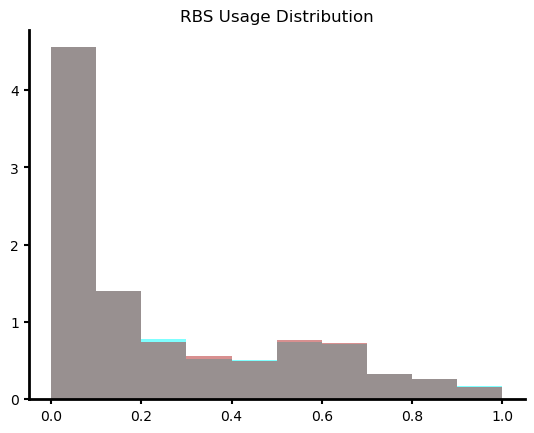

In [3]:
y_train = np.load('../data/RBS_Data/targets_train_validation.npy')
print(y_train.shape)

y_test = np.load('../data/RBS_Data/targets_test.npy')
print(y_test.shape)

plt.figure()
plt.title('RBS Usage Distribution')
plt.hist(y_train,color='cyan',density=True,alpha=0.5)
plt.hist(y_test,color='firebrick',density=True,alpha=0.5)
plt.subplot().spines['right'].set_visible(False)
plt.subplot().spines['top'].set_visible(False)
plt.subplot().spines['left'].set_linewidth(2.0)
plt.subplot().spines['bottom'].set_linewidth(2.0)
plt.subplot().xaxis.set_tick_params(width=1.5)
plt.subplot().yaxis.set_tick_params(width=1.5)

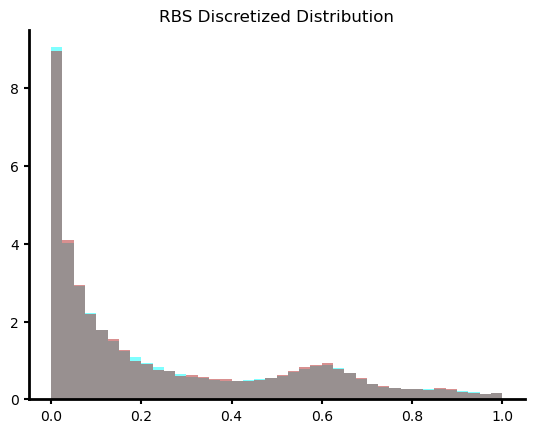

In [4]:
from sklearn.preprocessing import KBinsDiscretizer

#Binning into 0.05 sized bins like the original paper
# kbins = KBinsDiscretizer(n_bins=20, encode='ordinal', strategy='uniform')
# kbins.fit(y_train.reshape(-1,1))

# y_train = kbins.transform(y_train.reshape(-1,1)) * 0.05
# y_test = kbins.transform(y_test.reshape(-1,1)) * 0.05

plt.figure()
plt.title('RBS Discretized Distribution')
plt.hist(y_train,color='cyan',density=True,alpha=0.5,bins=40)
plt.hist(y_test,color='firebrick',density=True,alpha=0.5,bins=40)
plt.subplot().spines['right'].set_visible(False)
plt.subplot().spines['top'].set_visible(False)
plt.subplot().spines['left'].set_linewidth(2.0)
plt.subplot().spines['bottom'].set_linewidth(2.0)
plt.subplot().xaxis.set_tick_params(width=1.5)
plt.subplot().yaxis.set_tick_params(width=1.5)


In [5]:
seq_train = pd.DataFrame(data=seq_train,columns=['Sequences'])
seq_train.head()

seq_test = pd.DataFrame(data=seq_test,columns=['Sequences'])

seq_test.head()

,Sequences
0,AAAAAACAGTCTAGATT
1,AAAAAACGATGAGTCGG
2,AAAAAAGAAAAAAACAT
3,AAAAAAGAAAACTTCCC
4,AAAAAAGAGAAAAATCT


In [10]:
seq_df = pd.concat((seq_train,seq_test),axis=0)

seq_df.shape

y = np.concatenate((y_train,y_test),axis=0)

In [11]:
seqs = util.one_hot_encode(seq_df)
ppms = GA_util.prototype_ppms_fast(seqs)

In [ ]:
FOLDS = 3
BATCH_SIZE=64

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from scipy.stats import spearmanr

loss = 'mse'
lr = 0.0001
batch_size = 64
epochs = 20
folds = 3


joint_r2_save = []
joint_spearman_save = []
joint_mse_save = []



for i in range(folds):
    
    seq_train,seq_test,ppm_train,ppm_test,y_train,y_test = train_test_split(seqs,ppms,y,test_size=0.2)
    
    joint_model = GA_util.create_SANDSTORM(seq_len = 17,ppm_len=17,internal_activation='relu',latent_dim=64,output_activation='linear')
    optimizer = keras.optimizers.Adam(learning_rate=lr)
    joint_model.compile(optimizer=optimizer,loss='mse')
    epochs=20
    hist = joint_model.fit(
        [seq_train,ppm_train],y_train,batch_size=64,validation_data=[[seq_test,ppm_test],y_test],epochs=epochs)
 
    y_preds = joint_model.predict([seq_test,ppm_test])
    joint_mse = hist.history['val_loss'][-1]
    joint_r2 = r2_score(y_test,y_preds)
    joint_spearman = spearmanr(y_test,y_preds)[0]
    
    joint_mse_save.append(joint_mse)
    joint_r2_save.append(joint_r2)
    joint_spearman_save.append(joint_spearman)
    print(r2_score(y_test,y_preds))

Metal device set to: Apple M1 Ultra


2024-11-20 10:29:07.038509: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-20 10:29:07.038533: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/20


2024-11-20 10:29:07.432244: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-11-20 10:29:07.725744: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3794/3794 [==============================] - ETA: 0s - loss: 0.0191

2024-11-20 10:29:40.990849: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3794/3794 [==============================] - 37s 9ms/step - loss: 0.0191 - val_loss: 0.0143
Epoch 2/20
3794/3794 [==============================] - 35s 9ms/step - loss: 0.0135 - val_loss: 0.0124
Epoch 3/20
3794/3794 [==============================] - 34s 9ms/step - loss: 0.0120 - val_loss: 0.0113
Epoch 4/20
3794/3794 [==============================] - 30s 8ms/step - loss: 0.0112 - val_loss: 0.0108
Epoch 5/20
3794/3794 [==============================] - 30s 8ms/step - loss: 0.0107 - val_loss: 0.0102
Epoch 6/20
3794/3794 [==============================] - 30s 8ms/step - loss: 0.0102 - val_loss: 0.0098
Epoch 7/20
3794/3794 [==============================] - 30s 8ms/step - loss: 0.0098 - val_loss: 0.0096
Epoch 8/20
3794/3794 [==============================] - 30s 8ms/step - loss: 0.0095 - val_loss: 0.0094
Epoch 9/20
3794/3794 [==============================] - 31s 8ms/step - loss: 0.0093 - val_loss: 0.0091
Epoch 10/20
3794/3794 [==============================] - 31s 8ms/step - loss: 0.0091

2024-11-20 10:39:33.471238: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1897/1897 [==============================] - 5s 3ms/step
0.8800468551430317
Epoch 1/20


2024-11-20 10:39:39.342101: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3794/3794 [==============================] - ETA: 0s - loss: 0.0249

2024-11-20 10:40:07.630718: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3794/3794 [==============================] - 32s 8ms/step - loss: 0.0249 - val_loss: 0.0151
Epoch 2/20
3794/3794 [==============================] - 31s 8ms/step - loss: 0.0138 - val_loss: 0.0127
Epoch 3/20
3794/3794 [==============================] - 30s 8ms/step - loss: 0.0121 - val_loss: 0.0114
Epoch 4/20
3794/3794 [==============================] - 30s 8ms/step - loss: 0.0112 - val_loss: 0.0107
Epoch 5/20
3794/3794 [==============================] - 31s 8ms/step - loss: 0.0105 - val_loss: 0.0102
Epoch 6/20
3794/3794 [==============================] - 31s 8ms/step - loss: 0.0101 - val_loss: 0.0098
Epoch 7/20
3794/3794 [==============================] - 31s 8ms/step - loss: 0.0098 - val_loss: 0.0097
Epoch 8/20
3794/3794 [==============================] - 31s 8ms/step - loss: 0.0096 - val_loss: 0.0094
Epoch 9/20
3794/3794 [==============================] - 31s 8ms/step - loss: 0.0094 - val_loss: 0.0093
Epoch 10/20
3794/3794 [==============================] - 31s 8ms/step - loss: 0.0093

2024-11-20 10:54:37.961938: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1897/1897 [==============================] - 6s 3ms/step
0.878462642988311
Epoch 1/20


2024-11-20 10:54:44.306340: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3794/3794 [==============================] - ETA: 0s - loss: 0.0183

2024-11-20 10:55:13.554728: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3794/3794 [==============================] - 33s 8ms/step - loss: 0.0183 - val_loss: 0.0137
Epoch 2/20
3794/3794 [==============================] - 32s 8ms/step - loss: 0.0128 - val_loss: 0.0115
Epoch 3/20
3794/3794 [==============================] - 34s 9ms/step - loss: 0.0115 - val_loss: 0.0107
Epoch 4/20
3794/3794 [==============================] - 35s 9ms/step - loss: 0.0107 - val_loss: 0.0103
Epoch 5/20
3794/3794 [==============================] - 35s 9ms/step - loss: 0.0102 - val_loss: 0.0098
Epoch 6/20
3794/3794 [==============================] - 35s 9ms/step - loss: 0.0099 - val_loss: 0.0095
Epoch 7/20
3794/3794 [==============================] - 34s 9ms/step - loss: 0.0096 - val_loss: 0.0093
Epoch 8/20
3794/3794 [==============================] - 32s 9ms/step - loss: 0.0094 - val_loss: 0.0092
Epoch 9/20
3794/3794 [==============================] - 32s 8ms/step - loss: 0.0093 - val_loss: 0.0091
Epoch 10/20
3794/3794 [==============================] - 32s 8ms/step - loss: 0.0091

2024-11-20 11:05:41.733347: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1897/1897 [==============================] - 6s 3ms/step
0.8835811799606132


1897/1897 [==============================] - 5s 3ms/step


Text(0.5, 1.0, 'RBS Efficiency: R2 Score 0.8835811799606132')

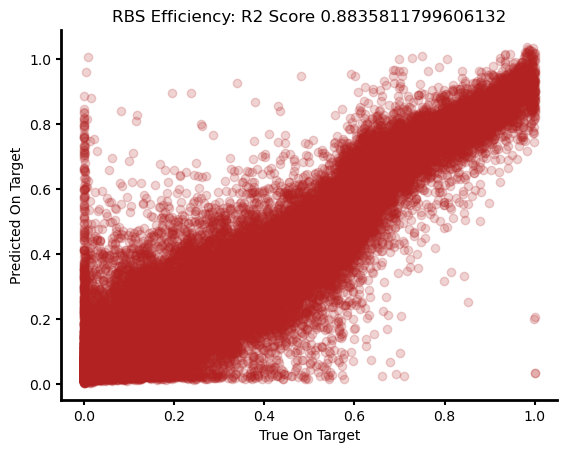

In [13]:
from sklearn.metrics import mean_absolute_error, r2_score, roc_auc_score, mean_squared_error

y_hat = joint_model.predict([seq_test,ppm_test])
# y_hat = np.reshape(y_hat, y_hat.shape[0]

# #Plot the fit of real and predicted values|
r2 = r2_score(y_test,y_hat)

plt.figure()
plt.scatter(y_test,y_hat,color='firebrick',alpha=0.2)
plt.subplot().spines['right'].set_visible(False)
plt.subplot().spines['top'].set_visible(False)
plt.subplot().spines['left'].set_linewidth(2.0)
plt.subplot().spines['bottom'].set_linewidth(2.0)
plt.subplot().xaxis.set_tick_params(width=1.5)
plt.subplot().yaxis.set_tick_params(width=1.5)
plt.xlabel('True On Target')
plt.ylabel('Predicted On Target')
plt.title('RBS Efficiency: R2 Score %s'%r2)
# plt.xlim([0,1])
# plt.ylim([0,1])
# plt.savefig('figures/Training Validation')



In [16]:
class BetaLayer(tf.keras.layers.Layer):
    """Tranform the shape parameters into mean and variance of the beta
    distributions"""
    def __init__(self, **kwargs):
        super(BetaLayer, self).__init__(**kwargs)
    
    def build(self, input_shape):
        super(BetaLayer, self).build(input_shape)
    
    def call(self, x):
        a, b = tf.split(tf.stack(x), 2, axis=2)  # a, b are n_models x n_samples
        a_plus_b = a + b

        # mu, sigma2 are n_models x n_samples
        mu = a / a_plus_b
        sigma2 = (a * b) / (K.square(a_plus_b) * (a_plus_b + 1))
             
        predictive_mean = K.mean(mu, axis=0)
        predictive_var = K.mean(sigma2, axis=0) + K.var(mu, axis=0)
        out = [predictive_mean, predictive_var]
        return out

In [17]:
input_shape = np.zeros((1, 17, 4))  # input size
model_number = [1, 2]  # set of hyperparameters
epoch_number = [52, 52]  # epoch (divided by 5) chosen after early stopping
seed_ensemble = [10, 20, 30, 40, 50]  # seeds of the elements of the ensemble

def beta2mean_var(output_beta):
    """Calculate the mean and variance of the beta distribution from the 
    shape parameters"""
    mean = output_beta[:, 0] / (output_beta[:, 1] + output_beta[:, 0])
    variance = (output_beta[:, 0] * output_beta[:, 1]) / (
			(output_beta[:, 0] + output_beta[:, 1])**2
                        * (output_beta[:, 0] + output_beta[:, 1] + 1))
    return mean, variance

In [11]:
import numpy as np
import matplotlib.pyplot as plt


size_bin = 0.05
percent_outlier = 0.5

def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value

def violinplot(ground_truth_targets, predicted_targets):

    # Bin the samples according to their ground truth target values.
    target_binned = []
    idx_outliers_per_bin = []
    target_binned_outliers = []
    for bins in np.arange(0, 1, size_bin):
        if bins == 1 - size_bin:
            idx = np.logical_and(ground_truth_targets >= bins, 
                                 ground_truth_targets <= bins + size_bin)
        else:
            idx = np.logical_and(ground_truth_targets >= bins, 
                                 ground_truth_targets < bins + size_bin)
        low_perc = np.percentile(predicted_targets[idx], percent_outlier)
        up_perc = np.percentile(predicted_targets[idx], 100 - percent_outlier)
        idx_outliers_per_bin.append(np.where(idx)[0][np.logical_or(
                                            predicted_targets[idx] < low_perc, 
                                            predicted_targets[idx] > up_perc)])
        idx_nonoutliers_per_bin = np.logical_and(predicted_targets[idx] >= low_perc, 
                                                 predicted_targets[idx] <= up_perc)
        idx_to_keep_per_bin = np.where(idx)[0][idx_nonoutliers_per_bin]

        target_binned.append(predicted_targets[idx_to_keep_per_bin])
    target_binned_outliers = [predicted_targets[idx] for idx in idx_outliers_per_bin]
    
    # Get summary statistics of the predicted values, per bin.
    percentile_info = np.array([
        np.percentile(target_binned[i], [25, 50, 75]) 
        for i in range(len(target_binned))])
    whiskers = np.array([
        adjacent_values(np.sort(bin_array), q1, q3)
        for bin_array, q1, q3 
        in zip(target_binned, percentile_info[:, 0], percentile_info[:, 2])])
    whiskersMin, whiskersMax = whiskers[:, 0], whiskers[:, 1]
    
    # Create the violin plot figure.
    fig = plt.figure(figsize=(18, 11.1255))
    # Plot violins.
    print(len(target_binned))
    print(target_binned)
    parts = plt.violinplot(target_binned, 
                           showmeans=False, 
                           showmedians=False, 
                           showextrema=False, 
                           widths=size_bin * 0.8, 
                           positions=np.arange(size_bin / 2, 1, size_bin), 
                           points=300,  
                           bw_method=None)
    # Set parameters of the plot.
    for pc in parts['bodies']:
        pc.set_facecolor('firebrick')
        pc.set_alpha(0.7)
    # Plot the outliers (scatter plot).
    for it, bin_id in enumerate(np.arange(0, 1, size_bin)):
        plt.scatter([bin_id + 0.025]*len(target_binned_outliers[it]), 
                    target_binned_outliers[it], color='blue', s=0.5)
    # Plot the summary statisics of predicted values, per bin.
    inds = np.arange(0, 1, size_bin) + 0.025
    plt.scatter(inds, percentile_info[:, 1], marker='o', 
                color='white', s=30, zorder=3)
    plt.vlines(inds, percentile_info[:, 0], percentile_info[:, 2], 
               color='k', linestyle='-', lw=5)
    plt.vlines(inds, whiskersMin, whiskersMax, 
               color='k', linestyle='-', lw=1)
    plt.plot([0, 1],[0, 1],'k')

    plt.xlabel('Ground truth $IFP_{0-480min}$ (bins of size 0.05)', fontsize=25)
    plt.ylabel('Predicted  $IFP_{0-480min}$', fontsize=25)

    plt.xticks(np.arange(size_bin / 2, 1, size_bin), 
               ['{:.2f}\n-\n{:.2f}'.format(i * size_bin, (i + 1) * size_bin) 
                for i in range(len(target_binned))], fontsize=12)
    plt.yticks(fontsize=16)
    plt.xlim(0, 1)
    plt.ylim(-0.01, 1.01)

    plt.savefig('Violin_plot.pdf')
    plt.show()
    
# preds = joint_model.predict([seq_test,ppm_test])
 
# violinplot(y_test,preds)

In [12]:
import tensorflow_probability as tfp
eps_ = 10**-6
eps = 10**-9

class UncerEstim():
    #Changing args to a dictionary
    def __init__(self, args):
        self.args = args
        self.loss_func = self.custom_objective()
    
    def nll_score(self, alpha_beta_groundtruth):
        """ Calculates the average negative log-likelihood over input samples"""
        dst = tfp.distributions.Beta(alpha_beta_groundtruth[0], 
                                    alpha_beta_groundtruth[1])
        target = K.clip(alpha_beta_groundtruth[2], eps_, 1 - eps_)
        return K.mean(-dst.log_prob(target))

    def residual_block(self, y, n_in, n_out, kmer_size=[3,3], stride=1):
        """ Defines the residual block, composed of two convolutional layers"""
        shortcut_in = y  
        
        conv1D_1 = layers.Conv1D(
	        n_in, 
	        kernel_size=kmer_size[0], 
	        strides=stride, 
	        kernel_regularizer=regularizers.l2(self.args['weight_decay']), 
	        padding='same')
        BN_1 = layers.BatchNormalization()
        y_in = conv1D_1(y)
        y_in = BN_1(y_in)
        y_in = layers.LeakyReLU()(y_in)
        
        conv1D_2 = layers.Conv1D(
		n_out, 
		kernel_size=kmer_size[1],  
		strides=1, 
                kernel_regularizer=regularizers.l2(self.args['weight_decay']), 
		padding='same')
        BN_2 = layers.BatchNormalization()
        y_in = conv1D_2(y_in)
        y_in = BN_2(y_in)                   

        if shortcut_in.shape[2] != n_out:
            conv1D_sh = layers.Conv1D(
		n_out, 
		kernel_size=1,  
		strides=stride, 
                kernel_regularizer=regularizers.l2(self.args['weight_decay']), 
		padding='same')
            BN_sh = layers.BatchNormalization()
            shortcut_in = conv1D_sh(shortcut_in)
            shortcut_in = BN_sh(shortcut_in)              

        y_in = layers.add([shortcut_in, y_in])
        y_in = layers.LeakyReLU()(y_in)
        return y_in
    
    def core_model(self, x_in):
        """Defines the deep learning model"""
        n_modules = len(self.args['n_blocks_res'])
        # Implements the sequence of residual blocks.  
        for module in range(n_modules):
            for block in range(self.args['n_blocks_res'][module]):
                stride = 1
                x_in = self.residual_block(
			x_in, 
			int(self.args['n_filters_res'][module * 2]), 
			int(self.args['n_filters_res'][module * 2 + 1]), 
                        kmer_size=[int(self.args['kmer_sizes_res'][module * 2]),
				   int(self.args['kmer_sizes_res'][module * 2 + 1])], 
			stride=stride)
        # Flattens the last convolutional layer's output.
        x_in = layers.Flatten()(x_in)
        
	# Implements the two first fully-connected layers.
        dense_alpha = layers.Dense(
		self.args['n_units_mlp'], 
		kernel_regularizer=regularizers.l2(self.args['weight_decay']))
        BN_alpha = layers.BatchNormalization() 
        alpha_hidden = dense_alpha(x_in)
        alpha_hidden = BN_alpha(alpha_hidden)
        alpha_hidden = layers.LeakyReLU()(alpha_hidden)

        dense_beta = layers.Dense(
		self.args['n_units_mlp'], 
		kernel_regularizer=regularizers.l2(self.args['weight_decay']))
        BN_beta = layers.BatchNormalization()
        beta_hidden = dense_beta(x_in)
        beta_hidden = BN_beta(beta_hidden)
        beta_hidden = layers.LeakyReLU()(beta_hidden)
        
        # Implements the two fully-connected layers that lead to the two output values.
        dense_output_alpha = layers.Dense(1, activation='softplus')
        dense_output_beta = layers.Dense(1, activation='softplus') 
        alpha = dense_output_alpha(alpha_hidden)
        beta = dense_output_beta(beta_hidden)
        add_epsilon = layers.Lambda(lambda x: x + eps)
        self.alpha = add_epsilon(alpha)
        self.beta = add_epsilon(beta)
            
        
    def sequence_model(self, inputs, targets):
        """Computes output"""
        self.core_model(x_in=inputs)
        self.nll = layers.Lambda(self.nll_score)(
		[self.alpha, self.beta, targets])
        return layers.Concatenate()([self.alpha, self.beta]) 
        
    def custom_objective(self):
        """Computes cost function"""
        nll_loss = self.nll_score
        def loss_function_in(y_true, y_pred):
            value_alpha, value_beta = layers.Lambda(
		lambda x: tf.split(x, 2, axis=1))(y_pred)
            loss = nll_loss(
		[value_alpha, value_beta, y_true])
            return loss
        return loss_function_in

In [13]:
from keras import backend as K
import random


random.seed(19847)

hyperparameters = {
         'n_blocks_res': [1, 1, 1],
         'n_filters_res': [64, 64, 64, 64, 64, 64],
         'kmer_sizes_res': [9, 1, 9, 1, 9, 1],
         'n_units_mlp': 64,
         'learning_rate': 0.01,
         'batch_size': 512,
         'weight_decay': 10**(-6)
         }    

In [14]:
from keras import activations, layers, models, optimizers, regularizers


#Format data for SAPIEN Model
sapien_seq_train = tf.transpose(seq_train,(0,2,1))
sapien_seq_test = tf.transpose(seq_test,(0,2,1))


# Initialise the lists that will save the output of the model.
shape_parameters_val_to_save = []
shape_parameters_tst_to_save = []
mean_and_variance_val_to_save = []
mean_and_variance_tst_to_save = []

# Build the model. 
US = UncerEstim(hyperparameters)  
network_input = layers.Input(shape=(sapien_seq_train.shape[1], 
			            sapien_seq_train.shape[2]))
network_target = layers.Input(shape=(1,))  
network_output = US.sequence_model(inputs=network_input, 
				   targets=network_target)
sapien_model = models.Model(inputs=[network_input], 
                     outputs=[network_output])
loss_func = US.custom_objective()
sapien_model.compile(optimizer=optimizers.Adam(lr=0.01), loss=loss_func) 
sapien_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 17, 4)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 17, 64)       2368        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 17, 64)      256         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 17, 64)       0           ['batch_normalization[0][0]']

/opt/homebrew/Caskroom/miniforge/base/envs/GARDN/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
epochs = 52
sapien_hist = sapien_model.fit(
    sapien_seq_train,y_train,batch_size=64,validation_data=[sapien_seq_test,y_test],epochs=epochs)

Epoch 1/52


2023-08-31 14:03:36.068355: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-08-31 14:03:36.865040: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4311/4311 [==============================] - ETA: 0s - loss: -1.4397

2023-08-31 14:07:37.634541: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4311/4311 [==============================] - 256s 59ms/step - loss: -1.4397 - val_loss: -1.4335
Epoch 2/52
4311/4311 [==============================] - 260s 60ms/step - loss: -1.5113 - val_loss: -1.5336
Epoch 3/52
4311/4311 [==============================] - 260s 60ms/step - loss: -1.5283 - val_loss: -1.4983
Epoch 4/52
4311/4311 [==============================] - 263s 61ms/step - loss: -1.5440 - val_loss: -1.5632
Epoch 5/52
4311/4311 [==============================] - 268s 62ms/step - loss: -1.5553 - val_loss: -1.5467
Epoch 6/52
4311/4311 [==============================] - 267s 62ms/step - loss: -1.5637 - val_loss: -1.5716
Epoch 7/52
4311/4311 [==============================] - 268s 62ms/step - loss: -1.5717 - val_loss: -1.5550
Epoch 8/52
4311/4311 [==============================] - 262s 61ms/step - loss: -1.5769 - val_loss: -1.3015
Epoch 9/52
4311/4311 [==============================] - 262s 61ms/step - loss: -1.5817 - val_loss: -1.5550
Epoch 10/52
4311/4311 [=========================

In [ ]:
print('loaded')

In [15]:
our_params = np.sum([np.prod(v.get_shape()) for v in joint_model.trainable_weights])
print(our_params)

sapien_params = np.sum([np.prod(v.get_shape()) for v in sapien_model.trainable_weights])
print(sapien_params)

11321
229698


In [22]:
#Saved these runs individually as sapiens model would crash kernel if ran more than once consecutively

joint_one = np.load('stat_tests/joint_rbs_r2.npy')
joint_two = np.load('stat_tests/joint_rbs_r2_2.npy')
joint_three = np.load('stat_tests/joint_rbs_r2_3.npy')

joint_r2 = [joint_one,joint_two,joint_three]

joint_spearman_one = np.load('stat_tests/joint_rbs_spearman.npy')
joint_spearman_two = np.load('stat_tests/joint_rbs_spearman_2.npy')
joint_spearman_three = np.load('stat_tests/joint_rbs_spearman_3.npy')


joint_spearman = [joint_spearman_one[0],joint_spearman_two[0],joint_spearman_three[0]]


sapien_one = np.load('stat_tests/sapien_model_r2_1.npy')
sapien_two = np.load('stat_tests/sapien_model_r2_2.npy')
sapien_three = np.load('stat_tests/sapien_model_r2_3.npy')

sapien_r2 = [sapien_one,sapien_two,sapien_three]

sapien_spearman_one = np.load('stat_tests/sapien_model_spearman_1.npy')
sapien_spearman_two = np.load('stat_tests/sapien_model_spearman_2.npy')
sapien_spearman_three = np.load('stat_tests/sapien_model_spearman_3.npy')

sapien_spearman = [sapien_spearman_one[0],sapien_spearman_two[0],sapien_spearman_three[0]]

In [23]:
joint_model_bars = [np.mean(joint_r2),
                    np.mean(joint_spearman),
                    our_params/sapien_params]


joint_model_variances = [np.std(joint_r2),
                         np.std(joint_spearman),
                         0]
                

sapien_model_bars = [np.mean(sapien_r2),
                    np.mean(sapien_spearman),
                    sapien_params/sapien_params]

sapien_model_variances = [np.std(sapien_r2),
                         np.std(sapien_spearman),
                         0]

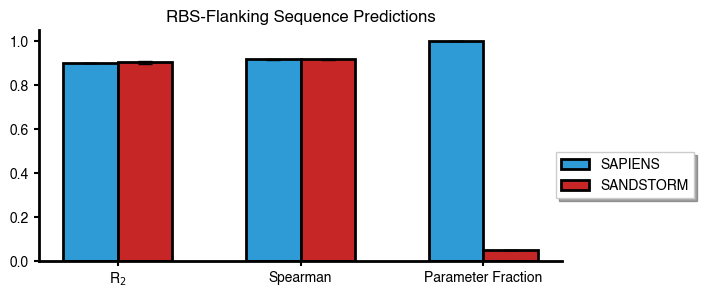

In [20]:
RED = '#C62626'
BLUE = '#2E9AD6'

barwidth = 0.3
plt.rcParams.update({'font.size': 10,'font.family':'Helvetica'})
r1 = np.arange(len(joint_model_bars))
r2 = [x + barwidth for x in r1]

plt.figure(figsize=(6.75,3))

plt.title('RBS-Flanking Sequence Predictions')
plt.bar(r1, sapien_model_bars, width = barwidth, color = BLUE,alpha=1, yerr=sapien_model_variances, capsize=5,edgecolor='black',linewidth=2, label='SAPIENS')

plt.bar(r2, joint_model_bars, width = barwidth, color = RED,alpha=1, yerr=joint_model_variances, capsize=5,edgecolor='black',linewidth=2, label='SANDSTORM')
plt.xticks([r + (barwidth/2) for r in range(len(joint_model_bars))], [r'R$_{\rm 2}$','Spearman','Parameter Fraction'])
plt.subplot().spines['right'].set_visible(False)
plt.subplot().spines['top'].set_visible(False)
plt.subplot().spines['left'].set_linewidth(2.0)
plt.subplot().spines['bottom'].set_linewidth(2.0)
plt.subplot().xaxis.set_tick_params(width=1.5)
plt.subplot().yaxis.set_tick_params(width=1.5)
plt.legend(loc='upper center', bbox_to_anchor=(1.12, 0.5),
          fancybox=False, shadow=True, ncol=1)
# plt.savefig('../figures/RBS Predictor.png',dpi=500,bbox_inches='tight',pad_inches=0.5)
plt.savefig('../figures/RBS Predictor.svg',transparent=True,bbox_inches='tight',pad_inches=0.5)

In [24]:
import scipy
joint_model_bars
joint_model_variances

save = []
for i in range(len(joint_model_bars)-1):
    save.append(scipy.stats.ttest_ind_from_stats(joint_model_bars[i], 
                                     joint_model_variances[i], 
                                     3,
                                     sapien_model_bars[i],
                                     sapien_model_variances[i],
                                     3, equal_var=True, alternative='two-sided'))

In [25]:
save

[Ttest_indResult(statistic=0.7487052589930744, pvalue=0.49565865995075764),
 Ttest_indResult(statistic=-0.06984308847287583, pvalue=0.9476708497196142)]